In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

trash = pd.read_csv('../data/trash_hauler_report_with_lat_lng.csv')
trash.head(2)

,Request Number,Date Opened,Request,Description,Incident Address,Zip Code,Trash Hauler,Trash Route,Council District,State Plan X,State Plan Y,LONGITUDE,LATITUDE
0,25270,11/1/2017,Trash - Backdoor,"house with the wheel chair ramp, they share dr...",3817 Crouch Dr,37207.0,RED RIVER,3205,2.0,1727970.412,686779.4781,-86.815392,36.217292
1,25274,11/1/2017,Trash - Curbside/Alley Missed Pickup,Curb/Trash miss Tuesday.,4028 Clarksville Pike,37218.0,RED RIVER,4202,1.0,1721259.366,685444.7996,-86.838103,36.213470


## Missed Trash Pickups

In this data question you will work with service request data related to missed trash pickups from [hubNashville](https://hub.nashville.gov), Metro Nashville government's comprehensive customer service system.

Your goal is to practice working with dates, times, and time-based aggregation in pandas while exploring patterns in missed pickups. You’ll also calculate fines based on missed pickups within a rolling time window.

**Step 1: Data Preparation**
1. Convert any date columns to datetime using pd.to_datetime().  

In [2]:
trash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20226 entries, 0 to 20225
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Request Number    20226 non-null  int64  
 1   Date Opened       20226 non-null  object 
 2   Request           20226 non-null  object 
 3   Description       20195 non-null  object 
 4   Incident Address  20217 non-null  object 
 5   Zip Code          20151 non-null  float64
 6   Trash Hauler      19325 non-null  object 
 7   Trash Route       19279 non-null  object 
 8   Council District  20177 non-null  float64
 9   State Plan X      20198 non-null  float64
 10  State Plan Y      20198 non-null  float64
 11  LONGITUDE         20198 non-null  float64
 12  LATITUDE          20198 non-null  float64
dtypes: float64(6), int64(1), object(6)
memory usage: 2.0+ MB


In [3]:
trash['Date Opened'] = pd.to_datetime(trash['Date Opened'],
                                      format = "%m/%d/%Y")
trash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20226 entries, 0 to 20225
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Request Number    20226 non-null  int64         
 1   Date Opened       20226 non-null  datetime64[ns]
 2   Request           20226 non-null  object        
 3   Description       20195 non-null  object        
 4   Incident Address  20217 non-null  object        
 5   Zip Code          20151 non-null  float64       
 6   Trash Hauler      19325 non-null  object        
 7   Trash Route       19279 non-null  object        
 8   Council District  20177 non-null  float64       
 9   State Plan X      20198 non-null  float64       
 10  State Plan Y      20198 non-null  float64       
 11  LONGITUDE         20198 non-null  float64       
 12  LATITUDE          20198 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(5)
memory usage: 2.0+ MB


2. Create new columns for:  
    * year, month, day
    * day_of_week (or weekday name)

In [4]:
trash['Month'] = trash['Date Opened'].dt.month_name()
trash['Year'] = trash['Date Opened'].dt.year
trash['Day'] = trash['Date Opened'].dt.day_name()
trash.head()

,Request Number,Date Opened,Request,Description,Incident Address,Zip Code,Trash Hauler,Trash Route,Council District,State Plan X,State Plan Y,LONGITUDE,LATITUDE,Month,Year,Day
0,25270,2017-11-01,Trash - Backdoor,"house with the wheel chair ramp, they share dr...",3817 Crouch Dr,37207.0,RED RIVER,3205,2.0,1727970.412,686779.4781,-86.815392,36.217292,November,2017,Wednesday
1,25274,2017-11-01,Trash - Curbside/Alley Missed Pickup,Curb/Trash miss Tuesday.,4028 Clarksville Pike,37218.0,RED RIVER,4202,1.0,1721259.366,685444.7996,-86.838103,36.213470,November,2017,Wednesday
2,25276,2017-11-01,Trash - Curbside/Alley Missed Pickup,Curb/trash miss Tuesday.,6528 Thunderbird Dr,37209.0,RED RIVER,4205,20.0,1707026.753,659887.4716,-86.885562,36.142923,November,2017,Wednesday
3,25307,2017-11-01,Trash - Curbside/Alley Missed Pickup,missed,2603 old matthews rd,37207.0,WASTE IND,2206,2.0,1735691.771,685027.2459,-86.789170,36.212652,November,2017,Wednesday
4,25312,2017-11-01,Trash - Curbside/Alley Missed Pickup,Missed the even side of the road.,604 croley dr,37209.0,RED RIVER,4203,20.0,1710185.772,664205.1011,-86.874995,36.154861,November,2017,Wednesday


3. Filter the data so that you are only analyzing actual missed pickups.

In [5]:
missed_trash_pickups = trash[(trash['Request'].str.contains('Missed Pickup'))]
missed_trash_pickups.head()

,Request Number,Date Opened,Request,Description,Incident Address,Zip Code,Trash Hauler,Trash Route,Council District,State Plan X,State Plan Y,LONGITUDE,LATITUDE,Month,Year,Day
1,25274,2017-11-01,Trash - Curbside/Alley Missed Pickup,Curb/Trash miss Tuesday.,4028 Clarksville Pike,37218.0,RED RIVER,4202,1.0,1721259.366,685444.7996,-86.838103,36.213470,November,2017,Wednesday
2,25276,2017-11-01,Trash - Curbside/Alley Missed Pickup,Curb/trash miss Tuesday.,6528 Thunderbird Dr,37209.0,RED RIVER,4205,20.0,1707026.753,659887.4716,-86.885562,36.142923,November,2017,Wednesday
3,25307,2017-11-01,Trash - Curbside/Alley Missed Pickup,missed,2603 old matthews rd,37207.0,WASTE IND,2206,2.0,1735691.771,685027.2459,-86.789170,36.212652,November,2017,Wednesday
4,25312,2017-11-01,Trash - Curbside/Alley Missed Pickup,Missed the even side of the road.,604 croley dr,37209.0,RED RIVER,4203,20.0,1710185.772,664205.1011,-86.874995,36.154861,November,2017,Wednesday
8,25330,2017-11-01,Trash - Curbside/Alley Missed Pickup,Missed.,4484 Lavergne Couchville Pike,37013.0,RED RIVER,4210,33.0,1794533.514,618749.3427,-86.588364,36.031728,November,2017,Wednesday


**Step 2: Explore Time-Based Patterns**  
Answer these simpler questions first:  
1. Which day of the week has the highest number of missed pickups?

In [6]:
missed_trash_pickups_by_day = missed_trash_pickups['Day'].value_counts()
day_with_most_missed_pickups = missed_trash_pickups_by_day.idxmax()
print(f"The day with the most missed pickups is: {day_with_most_missed_pickups}")

The day with the most missed pickups is: Friday


2. Missed pickups over time:  
    * Find the total number of missed pickups by month. Plot this with a line chart.  
    * Create a plot showing the number of missed pickups per day.  
    * Compute a rolling 30-day average of daily missed pickups. Visualize your results with a line chart to see trends.

In [7]:
missed_trash_pickups_by_month = missed_trash_pickups['Month'].value_counts()
month_with_most_missed_pickups = missed_trash_pickups_by_month.idxmax()
print(f"The month with the most missed pickups is: {month_with_most_missed_pickups}")

The month with the most missed pickups is: August


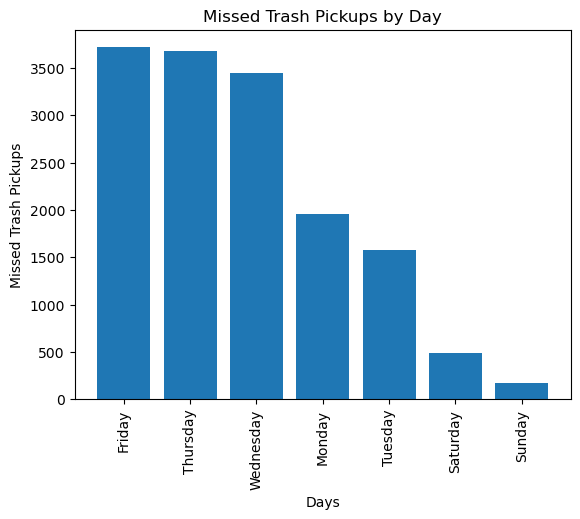

In [8]:
# Extract days and counts
days = missed_trash_pickups_by_day.index
counts = missed_trash_pickups_by_day.values 

# Create the bar chart with both x and height parameters
plt.bar(days, counts)
plt.xlabel('Days')
plt.xticks(rotation = 90)
plt.ylabel('Missed Trash Pickups')
plt.title('Missed Trash Pickups by Day')
plt.show()

In [9]:
missed_per_day = missed_trash_pickups.groupby('Date Opened').size().reset_index()
missed_per_day.columns = ['Date', 'missed_pickups']
missed_per_day['Date'] = pd.to_datetime(missed_per_day['Date'])
missed_per_day.head()

,Date,missed_pickups
0,2017-11-01,25
1,2017-11-02,29
2,2017-11-03,19
3,2017-11-05,2
4,2017-11-06,21


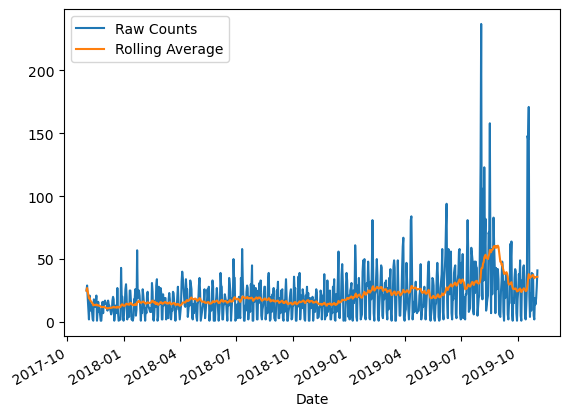

In [10]:
#rolling is different from groupby because it starts at the begining row, then we aggregate the column we want
missed_per_day['rolling_30D'] = missed_per_day.rolling(window = '30D', on='Date')['missed_pickups'].mean()

#then we plot
ax = missed_per_day.plot(x='Date', y='missed_pickups', label= 'Raw Counts')
missed_per_day.plot(x='Date', y='rolling_30D', label= 'Rolling Average', ax=ax);

**Step 3: Main Task – 180-Day Rolling Fine Calculation**  
Metro Nashville charges fines for excessive missed trash pickups. It uses the following method to calculate the total fine:  A $1500 fine is charged for each missed pickup that is the third or subsequent one at the same address within a 180-day window. Multiple fines may apply to the same address.  
What is the total fine across all addresses? **Hint:** The rolling method can be use in combination with groupby.

In [17]:
metro_missed_trash_pickups = trash[(trash['Trash Hauler'] != 'METRO')]
metro_missed_trash_pickups.head()

,Request Number,Date Opened,Request,Description,Incident Address,Zip Code,Trash Hauler,Trash Route,Council District,State Plan X,State Plan Y,LONGITUDE,LATITUDE,Month,Year,Day
0,25270,2017-11-01,Trash - Backdoor,"house with the wheel chair ramp, they share dr...",3817 Crouch Dr,37207.0,RED RIVER,3205,2.0,1727970.412,686779.4781,-86.815392,36.217292,November,2017,Wednesday
1,25274,2017-11-01,Trash - Curbside/Alley Missed Pickup,Curb/Trash miss Tuesday.,4028 Clarksville Pike,37218.0,RED RIVER,4202,1.0,1721259.366,685444.7996,-86.838103,36.213470,November,2017,Wednesday
2,25276,2017-11-01,Trash - Curbside/Alley Missed Pickup,Curb/trash miss Tuesday.,6528 Thunderbird Dr,37209.0,RED RIVER,4205,20.0,1707026.753,659887.4716,-86.885562,36.142923,November,2017,Wednesday
3,25307,2017-11-01,Trash - Curbside/Alley Missed Pickup,missed,2603 old matthews rd,37207.0,WASTE IND,2206,2.0,1735691.771,685027.2459,-86.789170,36.212652,November,2017,Wednesday
4,25312,2017-11-01,Trash - Curbside/Alley Missed Pickup,Missed the even side of the road.,604 croley dr,37209.0,RED RIVER,4203,20.0,1710185.772,664205.1011,-86.874995,36.154861,November,2017,Wednesday


In [18]:
metro_fines = metro_missed_trash_pickups.groupby('Incident Address').size().reset_index()
metro_fines.columns = ['Incident Address', 'num_incident']
metro_fines_filtered = metro_fines.query('num_incident >= 3')
metro_fines_filtered

,Incident Address,num_incident
25,"1000 2nd Ave N, Nashville, TN 37243, USA",3
32,"1000 Trevino Pl, Antioch, Tennessee, 37013",3
39,"1002 40th Ave N, Nashville, TN 37209, United S...",4
55,"1004 Chateau Valley Ct, Nashville, TN 37207, U...",3
60,"1004 Trevino Pl, Antioch, Tennessee, 37013",3
...,...,...
11580,"958 Battery Ln, Nashville, TN 37220, United St...",4
11584,"960 44th Ave N, Nashville, TN 37209, United St...",4
11610,"Farmhill Ct, Nashville, TN 37013, United States",3
11614,"Granbery Park Dr, Nashville, TN 37027, United ...",7


In [19]:
metro_missed_trash_pickups = pd.merge(metro_missed_trash_pickups, metro_fines, on='Incident Address', how='left')
metro_missed_trash_pickups

,Request Number,Date Opened,Request,Description,Incident Address,Zip Code,Trash Hauler,Trash Route,Council District,State Plan X,State Plan Y,LONGITUDE,LATITUDE,Month,Year,Day,num_incident
0,25270,2017-11-01,Trash - Backdoor,"house with the wheel chair ramp, they share dr...",3817 Crouch Dr,37207.0,RED RIVER,3205,2.0,1727970.412,686779.4781,-86.815392,36.217292,November,2017,Wednesday,1.0
1,25274,2017-11-01,Trash - Curbside/Alley Missed Pickup,Curb/Trash miss Tuesday.,4028 Clarksville Pike,37218.0,RED RIVER,4202,1.0,1721259.366,685444.7996,-86.838103,36.213470,November,2017,Wednesday,2.0
2,25276,2017-11-01,Trash - Curbside/Alley Missed Pickup,Curb/trash miss Tuesday.,6528 Thunderbird Dr,37209.0,RED RIVER,4205,20.0,1707026.753,659887.4716,-86.885562,36.142923,November,2017,Wednesday,1.0
3,25307,2017-11-01,Trash - Curbside/Alley Missed Pickup,missed,2603 old matthews rd,37207.0,WASTE IND,2206,2.0,1735691.771,685027.2459,-86.789170,36.212652,November,2017,Wednesday,1.0
4,25312,2017-11-01,Trash - Curbside/Alley Missed Pickup,Missed the even side of the road.,604 croley dr,37209.0,RED RIVER,4203,20.0,1710185.772,664205.1011,-86.874995,36.154861,November,2017,Wednesday,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16709,267121,2019-11-01,Trash - Curbside/Alley Missed Pickup,missed,"2709 Crestdale Dr, Nashville, TN 37214, United...",37214.0,RED RIVER,1502,15.0,1770240.199,676334.3993,-86.671860,36.189483,November,2019,Friday,1.0
16710,267125,2019-11-01,Trash - Curbside/Alley Missed Pickup,MISSED...NEIGHBORS MISSED,2731 Murfreesboro Pike,37013.0,RED RIVER,4502,32.0,1781137.263,632448.5511,-86.633970,36.069130,November,2019,Friday,13.0
16711,267130,2019-11-01,Trash - Curbside/Alley Missed Pickup,missed several,"2943 Windemere Cir, Nashville, TN 37214, Unite...",37214.0,RED RIVER,1502,15.0,1770293.388,674936.3038,-86.671647,36.185643,November,2019,Friday,2.0
16712,267134,2019-11-01,Trash - Curbside/Alley Missed Pickup,Caller stated trash was missed & were only pic...,"3325 Murfreesboro Pike, Nashville, TN 37013, U...",37013.0,RED RIVER,4502,32.0,1785224.998,627146.4002,-86.620025,36.054637,November,2019,Friday,4.0


In [20]:
metro_missed_trash_pickups.groupby('Incident Address').rolling(window = '180D', on='Date Opened')['num_incident'].count()

Incident Address                                          Date Opened
, Nashville, TN , United States                           2018-07-05     1.0
100 Bluefield Square, Nashville, TN 37214, United States  2019-03-15     1.0
100 Braxton Hill Ct                                       2018-03-07     1.0
100 Brook Hollow Rd                                       2018-12-05     1.0
100 Clydelan Ct, Nashville, TN 37205, United States       2019-02-14     1.0
                                                                        ... 
compton ave & 15th ave s                                  2018-08-22     1.0
fransworth dr                                             2018-02-21     1.0
s 13th st  & woodland st                                  2018-02-23     1.0
trimble rd & lindawood dr                                 2018-06-11     1.0
xavier dr                                                 2017-12-30     1.0
Name: num_incident, Length: 16706, dtype: float64

In [32]:
rolling = metro_missed_trash_pickups.groupby('Incident Address').rolling(window = '180D', on='Date Opened')['num_incident'].count()

In [33]:
rolling = rolling.reset_index()
rolling

,Incident Address,Date Opened,num_incident
0,", Nashville, TN , United States",2018-07-05,1.0
1,"100 Bluefield Square, Nashville, TN 37214, Uni...",2019-03-15,1.0
2,100 Braxton Hill Ct,2018-03-07,1.0
3,100 Brook Hollow Rd,2018-12-05,1.0
4,"100 Clydelan Ct, Nashville, TN 37205, United S...",2019-02-14,1.0
...,...,...,...
16375,compton ave & 15th ave s,2018-08-22,1.0
16376,fransworth dr,2018-02-21,1.0
16377,s 13th st & woodland st,2018-02-23,1.0
16378,trimble rd & lindawood dr,2018-06-11,1.0


In [34]:
rolling.loc[rolling['num_incident'] >= 3]

,Incident Address,Date Opened,num_incident
30,"1000 2nd Ave N, Nashville, TN 37243, USA",2019-07-10,3.0
40,"1000 Trevino Pl, Antioch, Tennessee, 37013",2019-10-28,3.0
50,"1002 40th Ave N, Nashville, TN 37209, United S...",2019-03-20,3.0
69,"1004 Chateau Valley Ct, Nashville, TN 37207, U...",2019-02-05,3.0
76,"1004 Trevino Pl, Antioch, Tennessee, 37013",2019-09-27,3.0
...,...,...,...
16345,"Granbery Park Dr, Nashville, TN 37027, United ...",2019-05-16,3.0
16346,"Granbery Park Dr, Nashville, TN 37027, United ...",2019-06-06,4.0
16347,"Granbery Park Dr, Nashville, TN 37027, United ...",2019-06-13,5.0
16348,"Granbery Park Dr, Nashville, TN 37027, United ...",2019-06-27,6.0


In [37]:
print(f'The total fine across all addresses is ${1665*1500}')

The total fine across all addresses is $2497500


**Step 4: Bonus Questions**
* What other types of complaints are there?
* Are there any geospatial patterns?
* How do metro crews compare to the contractor's performance?
* How much does each trash hauler owe?
* What were the total missed pickup by route?